In [25]:
import sys
sys.path.append('/usr/lib/python3.9/site-packages')
print(sys.executable)
import os
import random
import subprocess
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/Users/yochem/.local/share/pyenv/versions/krl/bin/python3


In [21]:
data_files = [
    'data/mts_june_10m.csv',
    'data/mts_june_10m_rh.csv',
    'data/mts_june_1m.csv',
    'data/mts_june_1m_rh.csv'
]

data_10m = pd.read_csv('data/mts_june_10m.csv')

data_10m.columns = ('start_time', 'transfer_time', 'req_id', 'bytes', 'completed')
print(len(data_10m['req_id']))



data_10m = data_10m.astype({'start_time': str, 'transfer_time': int, 'req_id': str, 'bytes': int, 'completed': bool})

4320


In [10]:
data_10m = data_10m[data_10m['transfer_time'] > 0]
data_10m.reset_index(inplace=True, drop=True)
data_10m
data_10m.describe().astype(int)

,transfer_time,bytes
count,4317,4317
mean,2451,986461130
std,8185,4862534123
min,145,8164772
25%,1241,144545848
50%,1840,412508945
75%,2592,912091472
max,299061,165483000000


## Exploring the transfer times of tasks

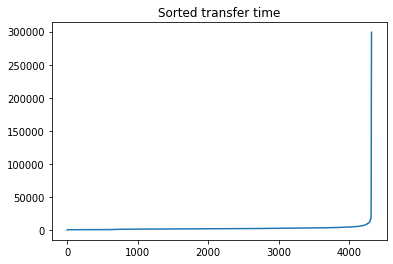

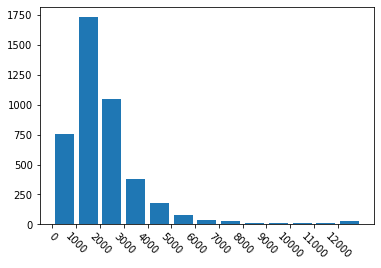

In [5]:
tt = data_10m['transfer_time']
plt.plot(sorted(tt))
plt.title('Sorted transfer time')
plt.show()

tt_dist = tt.apply(lambda t: t // 1000).value_counts().sort_index()

# sum 12000+ values
tt_dist[12] = tt_dist[12:].sum()
tt_dist = tt_dist[:13]
plt.bar(tt_dist.index, tt_dist.values)
plt.xticks(tt_dist.index - 0.5, labels=tt_dist.index * 1000, rotation=315)
plt.show()

count            4320
mean        985776088
std        4860914537
min                 0
25%         143993288
50%         412081398
75%         911894276
max      165483000000
Name: bytes, dtype: int64
575     165483000000
1583    140564000000
2591    132003000000
2707    128018000000
3562    116488000000
Name: bytes, dtype: int64


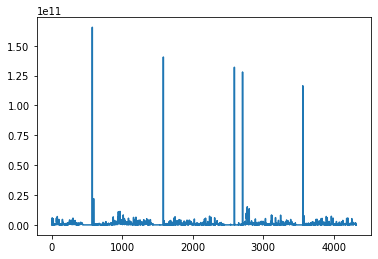

In [6]:
bytez = data_10m['bytes']

print(bytez.describe().astype(int))

print(bytez.loc[bytez > 1e11])
plt.plot(bytez)
plt.show()

### Arrival time

In [7]:
times = pd.to_datetime(data_10m['start_time'])

# everyday 144 tasks
times.groupby(times.dt.date).count()

start_time
2017-06-01    144
2017-06-02    144
2017-06-03    144
2017-06-04    144
2017-06-05    144
2017-06-06    144
2017-06-07    144
2017-06-08    144
2017-06-09    144
2017-06-10    144
2017-06-11    144
2017-06-12    144
2017-06-13    144
2017-06-14    144
2017-06-15    144
2017-06-16    144
2017-06-17    144
2017-06-18    144
2017-06-19    144
2017-06-20    144
2017-06-21    144
2017-06-22    144
2017-06-23    144
2017-06-24    144
2017-06-25    144
2017-06-26    144
2017-06-27    144
2017-06-28    144
2017-06-29    144
2017-06-30    144
Name: start_time, dtype: int64

In [8]:
times.groupby(times.dt.hour).count()

start_time
0     180
1     180
2     180
3     180
4     180
5     180
6     180
7     180
8     180
9     180
10    180
11    180
12    180
13    180
14    180
15    180
16    180
17    180
18    180
19    180
20    180
21    180
22    180
23    180
Name: start_time, dtype: int64

Conclusion, every 10 minutes a task for 30 days straight --> real-world like? Probably not



Idea: Generate graphs using daggen from this data, so it could be used with metarl offloading algorithm

## Generate DAG's using daggen

In [99]:
# this magic number is the 75% of the sorted data
# it gives a --n distribution of 25%: 0.157, 50%: 0.451, 75%: 1
flags = pd.DataFrame()
flags['mindata'] = data_10m.transfer_time.clip(lower=1)

# random values based on metarl-offloading
flags['density'] = np.repeat([.4, .5, .6, .7, .8], len(flags) // 5)
flags['ccr'] = np.repeat([.3, .4, .5], len(flags) // 3)
flags['fat'] = np.tile([.4, .5, .6, .7, .8], len(flags) // 5)

print(flags.describe())
flags

             mindata      density          ccr          fat
count    4320.000000  4320.000000  4320.000000  4320.000000
mean     2450.065972     0.600000     0.400000     0.600000
std      8182.582735     0.141438     0.081659     0.141438
min         1.000000     0.400000     0.300000     0.400000
25%      1240.000000     0.500000     0.300000     0.500000
50%      1840.000000     0.600000     0.400000     0.600000
75%      2592.000000     0.700000     0.500000     0.700000
max    299061.000000     0.800000     0.500000     0.800000


,mindata,density,ccr,fat
0,2319,0.4,0.3,0.4
1,1891,0.4,0.3,0.5
2,1053,0.4,0.3,0.6
3,1636,0.4,0.3,0.7
4,1087,0.4,0.3,0.8
...,...,...,...,...
4315,716,0.8,0.5,0.4
4316,672,0.8,0.5,0.5
4317,700,0.8,0.5,0.6
4318,647,0.8,0.5,0.7


In [106]:
GRAPH_FOLDER = 'graphs-20'


def create_cmd(row):
    cmd = subprocess.run([
        'daggen',
        '--dot',
        '-n', '20',
        '--mindata', str(int(row.mindata)),
        '--maxdata', str(int(row.mindata)),
        '--density', str(row.density),
        '--ccr', str(row.ccr),
        '--fat', str(row.fat),
        '--regular', '0.5',
        '-o', os.path.join(GRAPH_FOLDER, f'{int(row.name)}-{int(row.mindata)}.gv')
    ], capture_output=True)

    if cmd.returncode != 0:
        print(cmd.stderr.decode('utf-8').split('\n')[0])


# run to recreate
# flags.apply(create_cmd, axis=1)

0       None
1       None
2       None
3       None
4       None
        ... 
4315    None
4316    None
4317    None
4318    None
4319    None
Length: 4320, dtype: object

In [108]:
#  python3 -c 'import sys; from collections import Counter; print(Counter([round(eval(x), 2) for x in sys.argv[1:]]))' (grep expect_size * | cut -d' ' -f 4,6 | cut -d'"' -f 2,4 | sed 's/"/\//')
# Counter({2.5: 820, 2.0: 640, 3.33: 540})

# elke size heeft ook een expected size
def add_expect_size(start_folder):
    options = [2.5, 2, 3.3]

    for folder in os.listdir(start_folder):
        folder_path = os.path.join(start_folder, folder)
        if os.path.isfile(folder_path):
            continue

        print(folder_path)
        for filename in os.listdir(folder_path):
            with open(os.path.join(folder_path, filename), mode='r+') as f:
                lines = f.read().splitlines()
                new_lines = []
                for line in lines:
                    if '[size=' in line:
                        real_size = int(line.split('"')[1])
                        expect = int(real_size / random.choices(options, weights=[820, 640, 540])[0])
                        new_line = line[:-1] + f', expect_size="{expect}"]'
                    else:
                        new_line = line

                    new_lines.append(new_line)

                f.seek(0)
                f.truncate()
                f.write('\n'.join(new_lines))

            
add_expect_size('graphs-20')

graphs-20/03
graphs-20/04
graphs-20/32
graphs-20/35
graphs-20/34
graphs-20/33
graphs-20/05
graphs-20/02
graphs-20/20
graphs-20/18
graphs-20/27
graphs-20/11
graphs-20/29
graphs-20/16
graphs-20/28
graphs-20/17
graphs-20/10
graphs-20/19
graphs-20/26
graphs-20/21
graphs-20/07
graphs-20/38
graphs-20/00
graphs-20/36
graphs-20/09
graphs-20/31
graphs-20/30
graphs-20/37
graphs-20/08
graphs-20/01
graphs-20/06
graphs-20/39
graphs-20/24
graphs-20/23
graphs-20/15
graphs-20/12
graphs-20/13
graphs-20/14
graphs-20/22
graphs-20/25



Taillard specification
On the first line are two numbers, the first is the number of jobs and the second the number of machines. Following there are two matrice the first with a line for each job containing the processor times for each operation the second with the order for visiting the machines. The numbering of the machines starts at 1.

For example the same instance as above would be presented as:

```
1	3	
6	7	5
2	3	1
```


http://jobshop.jjvh.nl/explanation.php#taillard_def


In [112]:
from dataclasses import dataclass
from typing import List
from collections import Counter

task_sizes = np.array([30, 20, 50, 15])
weights = np.array([25, 21, 20, 10])
weights = weights / weights.sum()


# JOBS: Counter({30: 25, 20: 21, 50: 20, 15: 10, 100: 10})
# MACH: Counter({20: 40, 15: 45})
# task length from 0-100, scale bytes accordingly

def taillard(data, num_machines):
    group_count = len(data) // num_machines
    cutoff = group_count * num_machines
    even_data = data[:cutoff]
    groups = list(map(lambda t: t.values, np.array_split(even_data, group_count)))
    count = 0
    
    while groups:
        num_jobs = random.choices(task_sizes, weights)[0]
        
        # update
        instance = groups[:num_jobs]
        groups = groups[num_jobs:]
        job_paths = []
        
        for paths in instance:
            path_with_id = []
            machine_ids = list(range(num_machines))
            random.shuffle(machine_ids)
            for path in paths:
                path_with_id.append(machine_ids.pop())
                path_with_id.append(path)
                
            job_paths.append(' '.join(map(str, path_with_id)))
        
        with open(f'taillard/{num_jobs}-{num_machines}-{count}', 'w') as f:
            f.write(f'{num_jobs} {num_machines}\n')
            f.write('\n'.join(job_paths))
            f.write('\n')
        
        print('wrote file')
        count += 1
    
    
taillard(data_10m['transfer_time'], 15)

wrote file
wrote file
wrote file
wrote file
wrote file
wrote file
wrote file
wrote file
wrote file
wrote file
wrote file


In [58]:
a = [
    '25 75 75 76 38 62 38 59 14 13 46 31 57 92',
    '67 5 11 11 40 34 77 42 35 96 22 55 21 29',
    '22 98 8 35 59 31 13 46 52 22 18 19 64 29',
    '99 42 2 35 11 92 88 97 21 56 17 43 27 19',
    '50 5 59 71 47 39 82 35 12 2 39 42 52 65',
    '48 57 5 2 60 64 86 3 51 26 34 39 45 63',
    '40 43 50 71 46 99 67 34 6 95 67 54 29 30',
    '59 3 85 6 46 49 5 82 18 71 48 79 62 65',
    '65 55 81 15 32 52 97 69 82 89 69 87 22 71',
    '70 74 52 94 14 81 24 14 32 39 67 59 18 77',
    '18 6 96 53 35 99 39 18 14 90 64 81 89 48',
    '44 75 12 13 74 59 71 75 30 93 26 30 84 91',
    '39 56 13 29 55 69 26 7 55 48 22 46 50 96',
    '57 14 8 13 95 53 78 24 92 90 68 87 43 75',
    '93 92 18 28 27 40 56 83 51 15 97 48 53 78',
    '47 34 42 28 11 11 30 14 10 4 20 92 19 59',
    '69 82 64 40 27 82 27 43 56 17 18 20 98 43',
    '84 26 87 61 95 23 88 89 49 84 12 51 3 44',
    '43 54 18 72 70 28 20 22 59 36 85 13 73 29',
    '7 97 4 22 74 45 62 95 66 14 40 23 79 34',
]
for x in a:
    nums = list(map(int, x.split()))
    print(sum(nums))

701
545
516
649
600
583
731
678
886
715
750
777
611
797
779
421
686
796
622
662


In [3]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
# JOBS: Counter({30: 25, 20: 21, 50: 20, 15: 10, 100: 10})
vals = np.array([15, 20, 30, 50, 100])
weights = np.array([10, 21, 25, 20, 10])

plt.figure(figsize=(4.2, 2.7))
plt.tight_layout()
plt.bar(vals.astype(str), weights)
plt.xlabel('Number of jobs')
plt.ylabel('Count in original data')
plt.savefig('jobs.pgf', bbox_inches='tight')